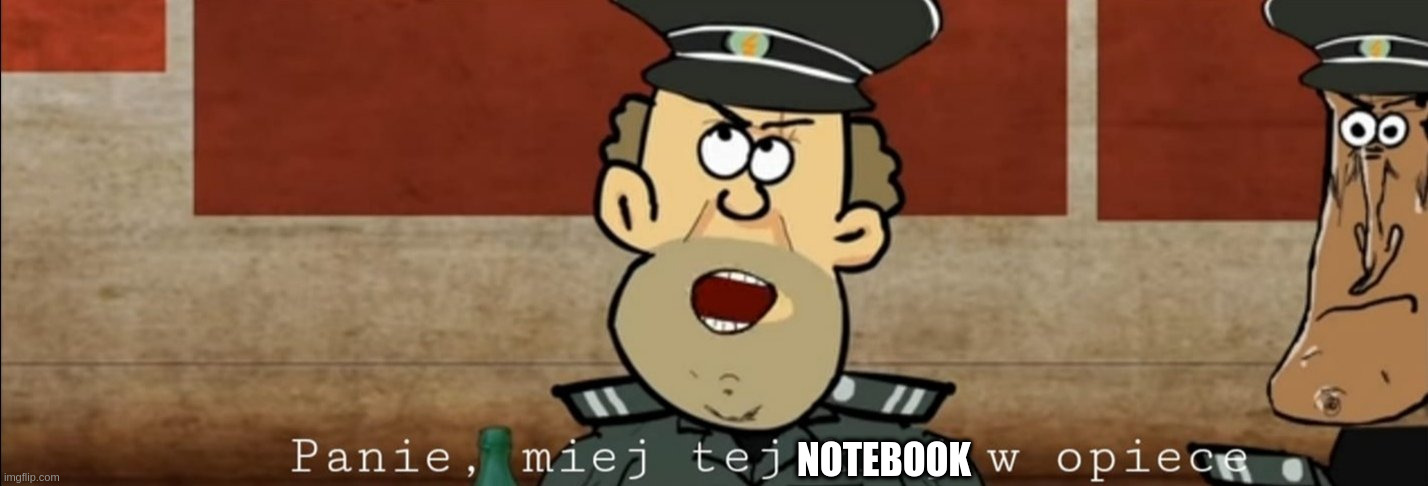

In [1]:
from IPython.display import Image
Image(filename='Panie.jpg') 

In [2]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
from numba import jit

In [3]:
data = np.loadtxt('TSPA.csv', delimiter=';').astype(np.int64)
data.shape

(200, 3)

In [4]:
def create_cost_matrix(data):
    x = data[:, :1]
    y = data[:, 1:2]
    cost = data[:, 2:3]
    return (((x - x.reshape(1, -1))**2 + (y - y.reshape(1, -1))**2) ** (1/2) + cost.reshape(1, -1)).round().astype(np.int32)

In [5]:
cost_matrix = create_cost_matrix(data)

In [6]:
cost_matrix

array([[  84, 2032, 2098, ..., 4159, 3783, 1514],
       [1633,  483, 2398, ..., 3349, 2266,  817],
       [ 720, 1419, 1462, ..., 3640, 3149,  964],
       ...,
       [2782, 2371, 3641, ..., 1461, 2908, 2554],
       [2558, 1440, 3302, ..., 3060, 1309, 1773],
       [1234,  936, 2062, ..., 3651, 2718,  364]], dtype=int32)

## TSP with regret

In [7]:
## slower first version
def calculate_k_regret(mat, bool_mask, k):
    mat = mat[~bool_mask][:, bool_mask]
    biggest_regret = 0 # what's yours? 
    id_biggest = None
    for i, sub_arr in enumerate(mat):
        sorted_values = sorted(sub_arr)[:k]
        regret_value = sum([sorted_values[i] - sorted_values[0] for i in range(1, k)])
        if regret_value > biggest_regret:
            biggest_regret = regret_value
            id_biggest = i

    new_node_id = bool_mask.index[~bool_mask][id_biggest]
    node_to_append = bool_mask.index[bool_mask][np.where(mat[id_biggest] == mat[id_biggest].min())[0]][0]
    
    return new_node_id, node_to_append, biggest_regret

In [8]:
def calculate_k_regret_new(mat, bool_mask, k):
    mat = mat[bool_mask][:, ~bool_mask].T
    biggest_regret = 0 # what's yours? 
    id_biggest = None
    
    sorted_mat = np.sort(mat, axis=1)
    regrets = (sorted_mat[:, 1:k] - sorted_mat[:, :1]).sum(axis=1) * (1 / sorted_mat[:, :1])
    biggest_regret = regrets.max()
    id_biggest = np.where(regrets == biggest_regret)[0][0]

    new_node_id = bool_mask.index[~bool_mask][id_biggest]
    node_to_append = bool_mask.index[bool_mask][np.where(mat[id_biggest] == mat[id_biggest].min())[0]][0]
    
    return new_node_id, node_to_append, biggest_regret

In [11]:
def tsp_regret(cost_matrix, starting_node, max_nodes, k=2, weigh=None):
    solution_set = set([starting_node])
    solution = [starting_node]

    ## regular greedy
    for i in range(k-1):
        previous_node = solution[-1]
        bool_mask = pd.Series(range(len(cost_matrix))).isin(solution_set)
        matrix_id = np.where(cost_matrix[previous_node][~bool_mask] == cost_matrix[previous_node][~bool_mask].min())[0][0]
        new_node = bool_mask.index[~bool_mask][matrix_id]
        solution_set.add(new_node)
        solution.append(new_node)
    total_time = 0
    
    ## tsp with regret
    while len(solution_set) < max_nodes:
        bool_mask_solution_nodes = pd.Series(range(len(cost_matrix))).isin(solution_set)
        new_node_id, node_to_append, regret_value = calculate_k_regret_new(cost_matrix, bool_mask_solution_nodes, k)
        solution.insert(solution.index(node_to_append)+1, new_node_id)
        solution_set.add(new_node_id)
    solution.append(solution[0])

    return solution

In [12]:
cycle = tsp_regret(cost_matrix, 0, 100, k=2)

In [13]:
pd.Series(cycle).nunique()

100

In [14]:
def plot(data, solution):
    data_ordered = np.array([data[i] for i in solution])

    plt.scatter(data_ordered[:,0], data_ordered[:,1], s=data_ordered[:,2]/data_ordered[:,2].max()*200)
    plt.plot(data_ordered[:,0], data_ordered[:,1], 'y-')
    plt.plot([data_ordered[0,0], data_ordered[-1,0]], [data_ordered[0,1], data_ordered[-1,1]], 'y-')
    plt.show()

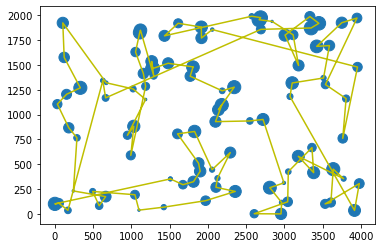

In [15]:
plot(data, cycle)

In [16]:
def calculate_performance(cycle, cost_matrix):
    total_sum = 0
    for i in range(len(cycle)-1):
        total_sum += cost_matrix[cycle[i], cycle[i+1]] 
    return total_sum

In [17]:
def test_solution(algorithm, cost_matrix, k):
    costs = []
    for i in range(len(cost_matrix)):
        cycle = algorithm(cost_matrix, i, 100, k)
        total_cost = calculate_performance(cycle, cost_matrix)
        costs.append(total_cost)
    costs = np.array(costs)
    return costs.min(), costs.max(), costs.mean()

In [18]:
test_solution(tsp_regret, cost_matrix, 2)

(85227, 90872, 87907.11)

In [19]:
test_solution(tsp_regret, cost_matrix, 3)

(85227, 90872, 87910.68)

In [20]:
test_solution(tsp_regret, cost_matrix, 4)

(85227, 90867, 87898.88)

In [160]:
from tqdm import tqdm

In [161]:
## Unweighted (comment a weighting line in code to get the unweighted result)
k_reg_dict = dict()
for i in tqdm(range(2, 100)):
    k_reg_dict[i] = test_solution(tsp_regret, cost_matrix, i)

100%|██████████| 98/98 [13:05<00:00,  8.02s/it]


<AxesSubplot:>

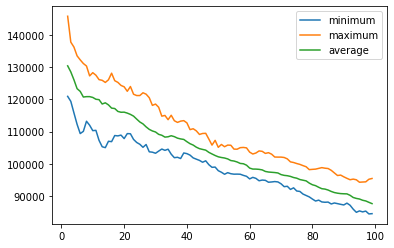

In [162]:
pd.DataFrame(k_reg_dict, index=['minimum', 'maximum', 'average']).T.plot()

In [181]:
## weighted
k_reg_dict_weighted = dict()
for i in tqdm(range(2, 100)):
    k_reg_dict_weighted[i] = test_solution(tsp_regret, cost_matrix, i)

100%|██████████| 98/98 [14:11<00:00,  8.68s/it]


<AxesSubplot:>

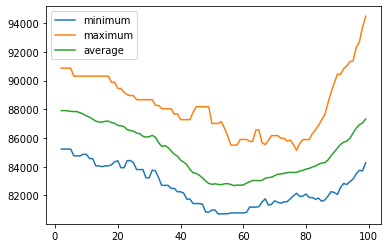

In [182]:
pd.DataFrame(k_reg_dict_weighted, index=['minimum', 'maximum', 'average']).T.plot()